In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def get_cal_score(data, labels):
    return metrics.calinski_harabasz_score(data, labels)

In [2]:
df = pd.read_csv('data.csv')
df.shape


(288, 7)

In [3]:
columns = list(df.columns)
columns

['index',
 'totalCarNumber',
 'numberOfTrips',
 'median_overhead',
 'q1_overhead',
 'q3_overhead',
 'p9_overhead']

In [4]:
df_before =df#.iloc[:144, :]


indexes = np.array_split(df_before.index,16, axis=0)
for i,index in enumerate(indexes):
    df_before.loc[index,'group'] = i
    
df_before['c'] = df_before['group'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# print(len(index_list))
# print('\n')
# print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# len(list_of_dfs)

In [5]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
#                 print(test_data)
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
#         plt.plot(silhouette_range[:], silhouette_scores[:], label = title)
#         plt.xlabel('Number of Clusters')
#         plt.ylabel('Silhouette Score')
#         plt.title(title)
#         plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
#         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
#         plt.show()
#         plt.close() 
        max_score = max(silhouette_scores)
#         print(results_dict)
        for i in results_dict:
            if i[1] == max_score:
#                 print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
#                 print(f'{max_score}')
                return int(i[0])
    else:
#         print('couldnt get the scores, plz help')
#         print('returning number of clusters = ' + str(n_clusters_min))
#         model_cpy = copy.deepcopy(model)
#         model_cpy.set_params(n_clusters=2)

#         model_cpy.partial_fit()
#         labels = model_cpy.predict(test_data)
#         s = metrics.silhouette_score(test_data, labels, metric='euclidean')
#         print(f'{s}')

        return n_clusters_min

In [6]:
def combine_dfs(df_list):
    return pd.concat(df_list)

In [7]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
    # to_drop = [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,265,266]
    # data_split_modified_z.drop(to_drop, inplace=True)
#     data_split_modified_z = data_split_modified_z.iloc[:144, :]
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#         print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

# a day of data (no accident)

In [8]:
model_005_before= Birch(n_clusters=None, threshold=0.2)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)


In [9]:
fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
#     add_data_to_this = pd.concat([add_data_to_this, i])
#     print(f'fit number: {fit_number}')

    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_005_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_005_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

51.89948072082354
93.4809737241591
170.5128007838145
286.36663286601726
348.73240939448056
410.4984850215157
332.4575428363244
424.30574757681546
4132.988469688765
3144.9474294517895
2325.072012483192
3008.2673856533497
3388.7027510471858
3194.7078447032386
3478.3504550966118
3044.640364579189


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
len(labels_dict)

8

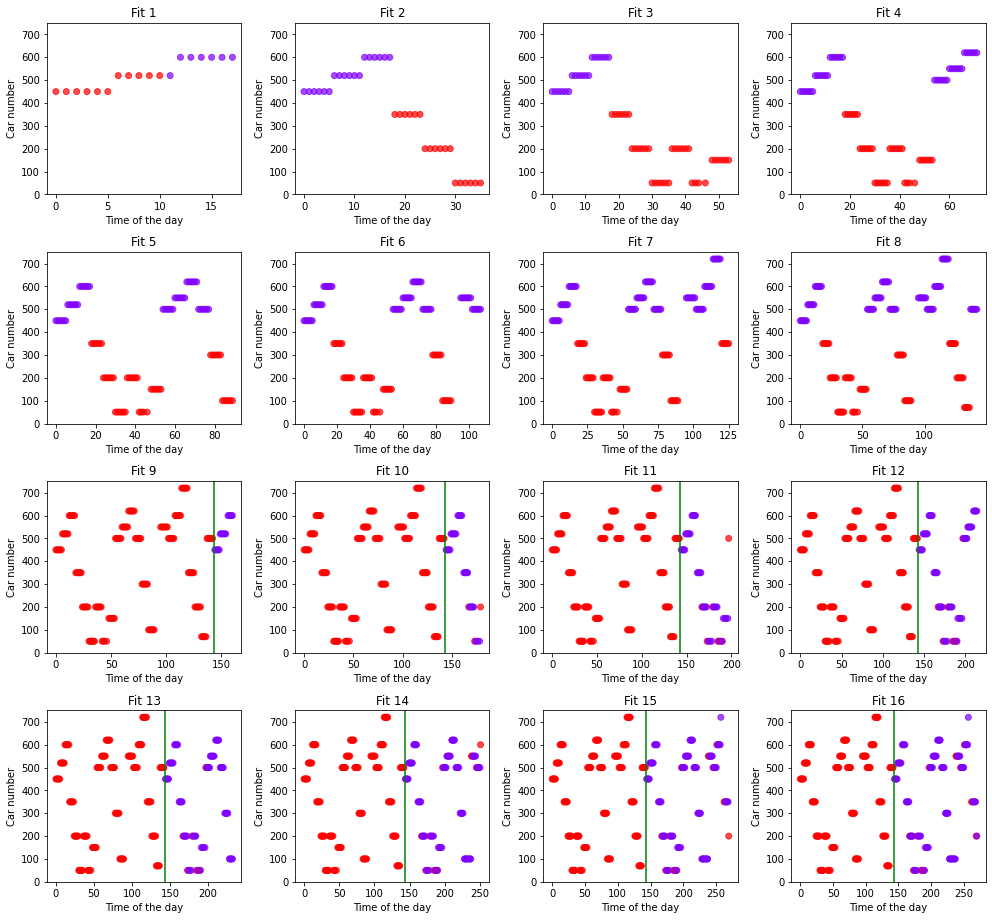

In [13]:
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 4
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,14))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [14]:
model_005_whole = Birch(n_clusters=None, threshold=0.01)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

In [15]:
fit_number = 1

for i in range(0, len(list_of_dfs)):
#     add_data_to_this = pd.concat([add_data_to_this, i])
#     print(f'fit number: {fit_number}')
    numpy_array = outliers_removal(list_of_dfs[i])
    removed_outliers_numpy.append(numpy_array)
    
    model_005_whole.partial_fit(numpy_array[:, :-2])
    model_copy = copy.deepcopy(model_005_whole)
    
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, 'threshold 0.05')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))

    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

59.66019123358649
93.4809737241591
188.59064498147887
231.7186153617076
348.73240939448056
410.4984850215157
332.4575428363244
424.30574757681546
4132.988469688765
3144.9474294517895
2325.072012483192
3008.2673856533497
3388.7027510471858
3194.7078447032386
3478.3504550966118


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


3044.640364579189


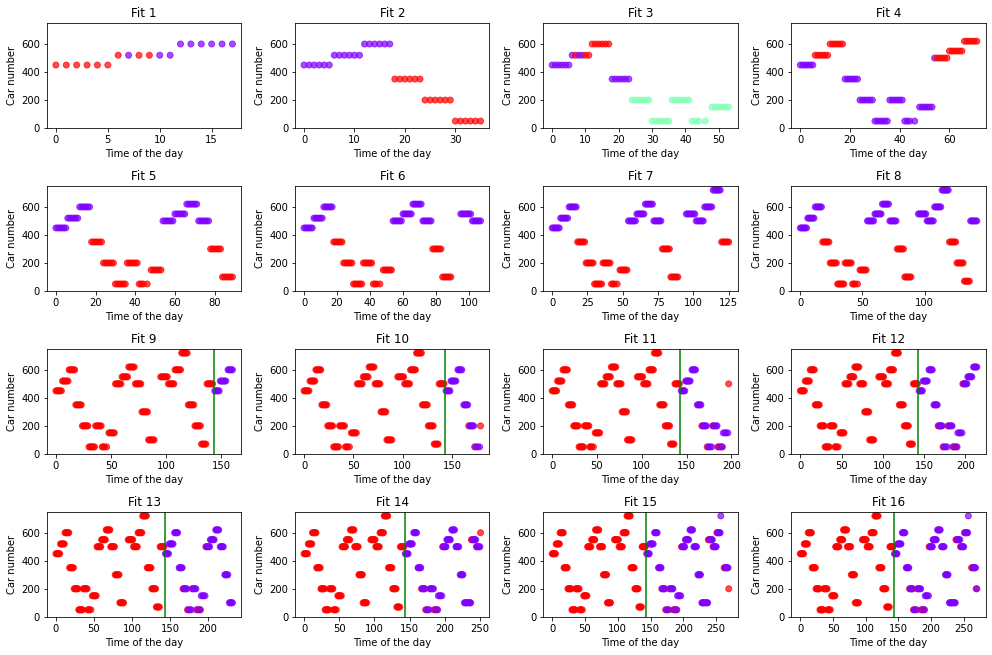

In [17]:
col_counter = 0
row_counter = 0

nrows = 4
ncols = 4

fit_number = 1

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,10))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1